In [2]:
using SparseArrays, Polynomials, PyCall, LinearAlgebra
using Plots
default(legend=false, linewidth=2)

In [3]:
"""
    mkanim(x, allu; [filename, axis])

Utility for animating PDE solutions.
"""
function mkanim(x, allu; filename=tempname() * ".mp4", axis=[0,1,-0.1,1.1])
    anim = @animate for i in 1:length(allu)
        plot(xlims=axis[1:2], ylims=axis[3:4])
        plot!(x[1], allu[i][1], linecolor=:blue)
        plot!(x[2], allu[i][2], linecolor=:black)
    end
    gif(anim, filename)
end

mkanim

In [4]:
"""
    function gauss_quad(p)

Gaussian quadrature on [-1,1] for given degree of precision `p`
"""
function gauss_quad(p)
    n = ceil((p+1)/2)
    b = 1:n-1
    b = @. b / sqrt(4*b^2 - 1)
    eval, evec = eigen(diagm(1 => b, -1 => b))
    return eval, 2*evec[1,:].^2
end

"""
    function legendre_poly(x, p)

Legendre polynomials and derivatives up to degree `p` at nodes `x`
"""
function legendre_poly(x, p)
    z = zeros(size(x))
    o = ones(size(x))
    y = hcat(o, x, repeat(z, 1, p-1))
    dy = hcat(z, o, repeat(z, 1, p-1))
    for i = 1:p-1
        @. y[:,i+2] = ((2i+1)*x*y[:,i+1] - i*y[:,i]) / (i+1)
        @. dy[:,i+2] = ((2i+1)*(x*dy[:,i+1] + y[:,i+1]) - i*dy[:,i]) / (i+1)
    end
    y, dy
end

xx = -1:0.01:1
p = 3
h = 0.1
s0 = [-cos(pi*i/p) for i=0:p] 
s = @. (s0 + 1) * h/2
gx, gw = gauss_quad(2*p)

yy,dyy = legendre_poly(gx, p)
#plot(gx, yy)

([1.0 -0.86113631159405 0.6123336207187071 -0.30474698495519564; 1.0 -0.3399810435848556 -0.32661933500442875 0.4117279996728991; 1.0 0.33998104358485715 -0.3266193350044272 -0.41172799967290014; 1.0 0.8611363115940526 0.6123336207187138 0.3047469849552061], [0.0 1.0 -2.58340893478215 4.061668103593536; 0.0 1.0 -1.0199431307545668 -0.6330966750221438; 0.0 1.0 1.0199431307545714 -0.633096675022136; 0.0 1.0 2.583408934782158 4.061668103593569])

In [70]:
function dgconvect(; n=10, p=1, T=1.0, dt=1e-3)
    # Discretization
    h = 1 / n
    #s = @. (0:p) / p
    s0 = [-cos(pi*i/p) for i=0:p] 
    s = @. (s0 + 1) * h/2 
    x = @. s + (0:h:1-h)'

    # Gaussian initial condition (and exact solution if shifted)
    uinit(x) = exp(-(x - 0.5)^2 / 0.1^2)

    yy, dyy = legendre_poly(s0, p)
    C = inv(yy)
    
    # Evaluate Legendre polynomials at Gaussian nodes
    gx, gw = gauss_quad(2*p)
    gyy, gdyy = legendre_poly(gx, p)

    # Basis function number i evaluated at Gaussian nodes
    gphi = gyy * C
    # Scale derivative 
    gphider = 2/h .* gdyy * C

    Mel = h/2 .* [dot(gphi[:,i] .* gphi[:,j], gw) for i=1:p+1, j=1:p+1]
    Kel = h/2 .* [dot(gphider[:,i] .* gphi[:,j], gw) for i=1:p+1, j=1:p+1]


    # RHS function in semi-discrete system
    function rhs(u)
        r = Kel * u
        r[end,:] = r[end,:] - u[end,:]
        r[1,:] = r[1,:] + u[end, [end; 1:end-1]]
        r = Mel \ r
    end

    # Setup
    u = uinit.(x)
    nsteps = round(Int, T/dt)

    # Setup plotting
    x2 = @. h*(0:1/(3*p-1):1) + (0:h:1-h)'
    x2 = reduce(vcat, x2)

    uplot = uinit.(x2)
    xplot = -1:2/(3p-1):1
    yyplot, dyyplot = legendre_poly(xplot, p)
    basis = yyplot*C
    
    xx = (0:0.01:1) # For exact solution
    allu = [ (uplot, uinit.(xx)) ]

    # Main loop
    for it = 1:nsteps
        # Runge-Kutta 4
        k1 = dt * rhs(u)
        k2 = dt * rhs(u + k1/2)
        k3 = dt * rhs(u + k2/2)
        k4 = dt * rhs(u + k3)
        u += (k1 + 2*k2 + 2*k3 + k4) / 6

        # Plotting
        if mod(it, round(nsteps/100)) == 0
            uexact = @. uinit(mod(xx - dt*it, 1.0))
            uplot = basis * u
            uplot = reduce(vcat, uplot)
            push!(allu, (uplot, uexact))
        end
    end

    #uexact = @. uinit(mod(x - T, 1.0))  # Exact final solution
    #error = maximum(abs.(u - uexact))   # Discrete inf-norm error""

    gu = gphi*u                             # Numerical solution evaluated at Gaussian nodes in each element
    gxx = @. h/2*(gx+1) + (0:h:1-h)'        # Gaussian nodes in each element
    guexact = @. uinit(mod(gxx - T, 1.0))   # Exact final solution evaluated at Gaussian nodes in each element

    difference = @. (gu-guexact)^2

    error = sqrt(sum(gw' * difference))

    return (x2,xx), allu, error
end


dgconvect (generic function with 1 method)

In [77]:
x, allu, error = dgconvect(p=4, n=5)
mkanim(x, allu, filename="PS7_1a.mp4")

┌ Info: Saved animation to /Users/alexanderhatle/Documents/Berkeley/math228b/Problem sets/PS7/PS7_1a.mp4
└ @ Plots /Users/alexanderhatle/.julia/packages/Plots/7R93Y/src/animation.jl:156


Plots.AnimatedGif("/Users/alexanderhatle/Documents/Berkeley/math228b/Problem sets/PS7/PS7_1a.mp4")

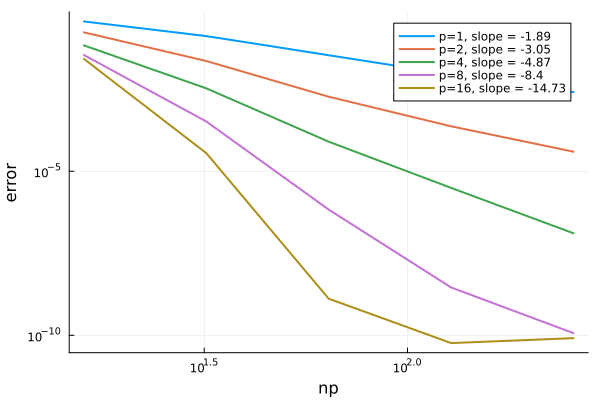

([0.3653733505294316 0.13076214557514357 … 0.008909357776609804 0.0025734055103463094; 0.16981885290409357 0.022763879152079083 … 0.00023359188566210697 3.926410116199392e-5; … ; 0.034659508299645335 0.00032694222517746813 … 2.872677088719751e-9 1.1627652664303327e-10; 0.026423535102662352 3.550907132129435e-5 … 5.8051477179982994e-11 8.20828849894169e-11], [-1.8940537479831456, -3.052990312297412, -4.8688616408897145, -8.398140179207362, -14.732362692727534])

In [83]:
function dgconvect_convergence()
    ps = [1,2,4,8,16]
    dt = 2 * 10^-4
    T = 1
    np = [16,32,64,128,256]

    errors = zeros(5,5)
    slopes = zeros(5)
    nps = zeros(5,5)
    throwaway = [0 0 0 1 2]
    
    convplot = plot(legend=true, xlabel="np", ylabel="error")
    for i = 1:5
        p = ps[i]
        for j = 1:5
            n = Int64(np[j]/p)
            x, allu, error = dgconvect(p=p, n=n, dt=dt, T=T)
            errors[i,j] = error
            nps[i,j] = n*p
        end
        fit = Polynomials.fit(log.(nps[i,begin+1:end-throwaway[i]]), log.(errors[i,begin+1:end-throwaway[i]]),1)
        slopes[i] = coeffs(fit)[2]

        plot!(nps[i,:], errors[i,:], xaxis=:log, yaxis=:log, labels="p=$(ps[i]), slope = $(round(slopes[i], digits=2))")
    end
  
    display(convplot)

    return errors, slopes
end

errors, slopes = dgconvect_convergence()

In [78]:
function dgconvdiff(; n=10, p=1, T=1.0, dt=1e-3,k=1e-3)

    # Discretization
    h = 1 / n
    #s = @. (0:p) / p
    s0 = [-cos(pi*i/p) for i=0:p] 
    s = @. (s0 + 1) * h/2 
    x = @. s + (0:h:1-h)'
    
    u_exact(x,t) = sum([1/sqrt(1+400*k*t) * exp(-100 * (x - 0.5 - t + i)^2 / (1+400*k*t)) for i=-2:2])

    yy, dyy = legendre_poly(s0, p)
    C = inv(yy)
    
    # Evaluate Legendre polynomials at Gaussian nodes
    gx, gw = gauss_quad(2*p)
    gyy, gdyy = legendre_poly(gx, p)

    
    # Basis function number i evaluated at Gaussian nodes
    gphi = gyy * C
    # Scale derivative 
    gphider = 2/h .* gdyy * C

    Mel = h/2 .* [dot(gphi[:,i] .* gphi[:,j], gw) for i=1:p+1, j=1:p+1]
    Kel = h/2 .* [dot(gphider[:,i] .* gphi[:,j], gw) for i=1:p+1, j=1:p+1]

    # RHS function in semi-discrete system
    function rhs(u)
        sigmar = -Kel * u
        sigmar[1,:] = sigmar[1,:] - u[1,:]
        sigmar[end,:] = sigmar[end,:] + u[1, [2:end; 1]]
        sigma = Mel \ sigmar

        r = Kel * (u - k .* sigma)
        r[end,:] = r[end,:] - (u[end,:] - k .* sigma[end,:])
        r[1,:] = r[1,:] + (u[end, [end; 1:end-1]] - k .* sigma[end, [end; 1:end-1]])
        r = Mel \ r
    end

    # Setup
    u = u_exact.(x,0)
    nsteps = round(Int, T/dt)
    
    # Setup plotting
    x2 = @. h*(0:1/(3*p-1):1) + (0:h:1-h)'
    x2 = reduce(vcat, x2)

    uplot = u_exact.(x2,0)
    xplot = -1:2/(3p-1):1
    yyplot, dyyplot = legendre_poly(xplot, p)
    basis = yyplot*C
    
    xx = (0:0.01:1) # For exact solution
    allu = [ (uplot, u_exact.(xx,0)) ]

    # Main loop
    for it = 1:nsteps
        # Runge-Kutta 4
        k1 = dt * rhs(u)
        k2 = dt * rhs(u + k1/2)
        k3 = dt * rhs(u + k2/2)
        k4 = dt * rhs(u + k3)
        u += (k1 + 2*k2 + 2*k3 + k4) / 6

        # Plotting
        if mod(it, round(nsteps/100)) == 0
            uexact = @. u_exact(xx, dt*it)
            uplot = basis * u
            uplot = reduce(vcat, uplot)
            push!(allu, (uplot, uexact))
        end
    end
    
    gu = gphi*u                             # Numerical solution evaluated at Gaussian nodes in each element
    gxx = @. h/2*(gx+1) + (0:h:1-h)'        # Gaussian nodes in each element
    guexact = @. u_exact(gxx, T)   # Exact final solution evaluated at Gaussian nodes in each element

    difference = @. (gu-guexact)^2

    error = sqrt(sum(gw' * difference))
  
    return (x2,xx), allu, error
end

x, allu, error = dgconvdiff(n=5, p=4)
mkanim(x, allu, filename="PS7_2a.mp4")

┌ Info: Saved animation to /Users/alexanderhatle/Documents/Berkeley/math228b/Problem sets/PS7/PS7_2a.mp4
└ @ Plots /Users/alexanderhatle/.julia/packages/Plots/7R93Y/src/animation.jl:156


Plots.AnimatedGif("/Users/alexanderhatle/Documents/Berkeley/math228b/Problem sets/PS7/PS7_2a.mp4")

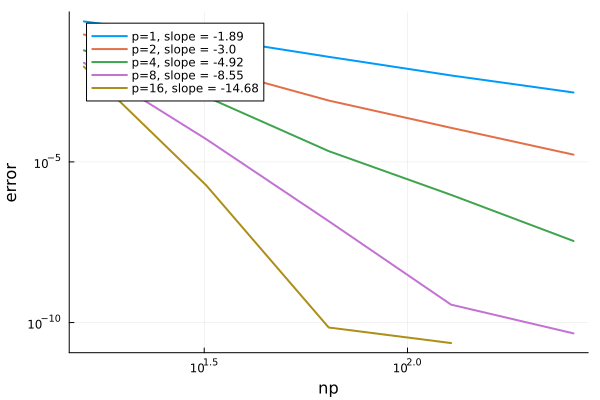

([0.234400342768452 0.07354862126287698 … 0.004894023262716814 0.0014445650146316857; 0.09196525944766418 0.008975775321778704 … 0.00011475270244058603 1.680295985240412e-5; … ; 0.012167358416587898 5.076976884389037e-5 … 3.612736275869954e-10 4.612108565887707e-11; 0.009192884163493394 1.8523608613630585e-6 … 2.305673101055259e-11 NaN], [-1.893479713945086, -3.0005204478733973, -4.922949686009872, -8.550259110885383, -14.68426431115684])

In [82]:
function dgconvdiff_convergence()
    ps = [1,2,4,8,16]
    dt = 2 * 10^-4
    T = 1
    np = [16,32,64,128,256]

    errors = zeros(5,5)
    slopes = zeros(5)
    nps = zeros(5,5)
    throwaway = [0 0 0 1 2]
    
    convplot = plot(legend=true, xlabel="np", ylabel="error")
    for i = 1:5
        p = ps[i]
        for j = 1:5
            n = Int64(np[j]/p)
            x, allu, error = dgconvdiff(p=p, n=n, dt=dt, T=T)
            errors[i,j] = error
            nps[i,j] = n*p
        end
        fit = Polynomials.fit(log.(nps[i,begin+1:end-throwaway[i]]), log.(errors[i,begin+1:end-throwaway[i]]),1)
        slopes[i] = coeffs(fit)[2]

        plot!(nps[i,:], errors[i,:], xaxis=:log, yaxis=:log, labels="p=$(ps[i]), slope = $(round(slopes[i], digits=2))")
    end
  
    display(convplot)

    return errors, slopes 
end

errors, slopes = dgconvdiff_convergence()